# Workshop 7. Классификация.

1. Скачайте этот ноутбук к себе.
2. Заполните пропущенные ячейки, отвечая на заданные вопросы. Там должен быть код! (если не сказано обратное)
3. Сохраните результат в своём гитхаб репозитории.

### Полезная литература

- [ODS - классификация](https://habrahabr.ru/company/ods/blog/322534/)
- [Коллаборативная фильтрация - рекомендательная система](https://ru.wikipedia.org/wiki/%D0%9A%D0%BE%D0%BB%D0%BB%D0%B0%D0%B1%D0%BE%D1%80%D0%B0%D1%82%D0%B8%D0%B2%D0%BD%D0%B0%D1%8F_%D1%84%D0%B8%D0%BB%D1%8C%D1%82%D1%80%D0%B0%D1%86%D0%B8%D1%8F)
- [Метрики расстояний - косинусная, минковского, проклятье размерности ](http://www.machinelearning.ru/wiki/images/9/9a/Sem1_knn.pdf)
- [Offtop: метрики качества рекомендаьельных систем](https://habrahabr.ru/company/dca/blog/281066/)

## kNN - ближайшие соседи

Рассмотрим задачу из соревнования [Amazon Employee Access Challenge](https://www.kaggle.com/c/amazon-employee-access-challenge).

В данной задаче предлагается предсказать, будет ли одобрен запрос сотрудника на получение доступа к тому или иному ресурсу. Все признаки являются категориальными.

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, KFold, cross_val_score
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import scale

In [2]:
df = pd.read_csv('./data/amazon.csv.gz')
df.head()
# ACTION - это целевой признак

,ACTION,RESOURCE,MGR_ID,ROLE_ROLLUP_1,ROLE_ROLLUP_2,ROLE_DEPTNAME,ROLE_TITLE,ROLE_FAMILY_DESC,ROLE_FAMILY,ROLE_CODE
0,1,39353,85475,117961,118300,123472,117905,117906,290919,117908
1,1,17183,1540,117961,118343,123125,118536,118536,308574,118539
2,1,36724,14457,118219,118220,117884,117879,267952,19721,117880
3,1,36135,5396,117961,118343,119993,118321,240983,290919,118322
4,1,42680,5905,117929,117930,119569,119323,123932,19793,119325


Обратим внимание, что выборка не сбалансированная. В качестве метрики качества будем использовть [f1-score](https://en.wikipedia.org/wiki/F1_score). 
$$F_1 = 2 \cdot \frac{\mathrm{precision} \cdot \mathrm{recall}}{\mathrm{precision} + \mathrm{recall}}$$

$$precision = \frac{TP}{TP+FP}$$

$$recall = \frac{TP}{TP+FN}$$

0.9421099209618847


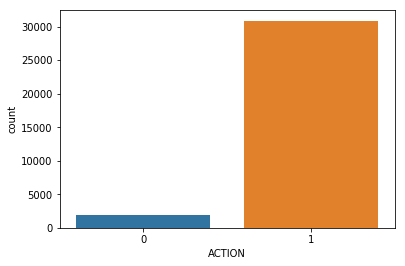

In [3]:
print(df['ACTION'].mean())
sns.countplot('ACTION', data=df)

In [4]:
# число значений у признаков
for col_name in df.columns:
    print(col_name, len(df[col_name].unique()))

ACTION 2
RESOURCE 7518
MGR_ID 4243
ROLE_ROLLUP_1 128
ROLE_ROLLUP_2 177
ROLE_DEPTNAME 449
ROLE_TITLE 343
ROLE_FAMILY_DESC 2358
ROLE_FAMILY 67
ROLE_CODE 343


In [5]:
X = df.drop(['ACTION'], axis=1)
y = df['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

# Baseline

Сразу проверим как ведет себя kNN на неподготовленных данных и без тюнинга. Зафиксируйте `n_neighbors=5`, `p=2`. 

- создайте экземпляр `KNeighborsClassifier` с указанными параметрами, обучите его методов `fit` и предскажите значения `predict` для треничровчных данных `X_test`.
- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Обратите внимание на confusion matrix. Какой вывод вы можете сделать из неё? Вспомните лекцию и значение ошибок 1 и 2 рода.

In [6]:
# p по дефолту =2
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.22      0.03      0.05      1534
           1       0.94      0.99      0.97     24682

   micro avg       0.94      0.94      0.94     26216
   macro avg       0.58      0.51      0.51     26216
weighted avg       0.90      0.94      0.91     26216



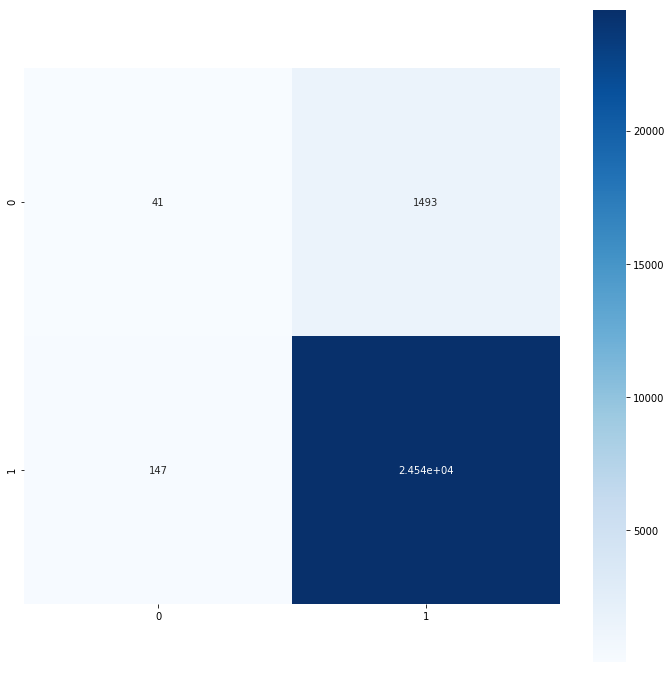

In [7]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

41 человек из 1534 действительно не должен получить доступ. Т.е. вероятность того, что тебе отказали КРАЙНЕ МАЛА. Как-то так. 

При фиксированном `n_neighbors=10` проверьте значение метрики на кроссвалидации на 5-фолдах для разных значений `p` из `(1,2,4,6)`. При каком значение `p` метрика достигает максимума?

При кроссвалидации у вас будет получаться N разных значений метрики. Выводите среднее значение и стандартное отклонение.

In [8]:
val_p = (1,2,4,6)
for p in val_p:
    clf = KNeighborsClassifier(n_neighbors=10, p=p)
    print("for p={} mean: {}".format(p, cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean()))
    print("for p={} std: {}".format(p, cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').std()))

for p=1 mean: -0.05962964657245858
for p=1 std: 0.0011535018987757493
for p=2 mean: -0.06020941258992131
for p=2 std: 0.0006856392417346533
for p=4 mean: -0.059934794423408835
for p=4 std: 0.0008774819685054348
for p=6 mean: -0.05996528685948978
for p=6 std: 0.0008243741057369957


# Счетчики

Очевидно, что предсказывать лейбл объекта, используя при этом метрический алгоритм на категориальных признаках - это ОЧЕНЬ странная затея. Не удивительно что качество ужасное. Необходимо каким-то образом заменить категориальные признаки вещественными:

- OneHotEncoding - это когда для каждого признака создают другие N бинарных признаков, где N - это количество категорий у категориального признака.
- Счетчики - об это написано в статье http://blogs.technet.com/b/machinelearning/archive/2015/02/17/big-learning-made-easy-with-counts.aspx.

Мы реализуем алгоритм Счетчиков. Его нет в sklearn, поэтому придется реализовать самому. 

Для каждого категориального признака создайте 3 других признака:
1. Число `counts` объектов в обучающей выборке с таким же значением признака.
2. Число `successes` объектов первого класса ($y = 1$) в обучающей выборке с таким же значением признака.
3. Сглаженное отношение двух предыдущих величин: (`successes` + 1) / (`counts` + 2).

Поскольку признаки, содержащие информацию о целевой переменной, могут привести к переобучению, может оказаться полезным сделать *фолдинг*: разбить обучающую выборку на $n$ частей, и для $i$-й части считать `counts` и `successes` по всем остальным частям. Для тестовой выборки используются счетчики, посчитанные по всей обучающей выборке. Реализуйте и такой вариант. Можно использовать $n = 3$.

Обучение надо проводить только по новым признакам. Изначальные мы не используем.

Подсказка - вам нужно для каждой колонки посчитать 2 аггрегации - сумму и количество. Для заменя конкретного значения посчитанным используйте функцию apply над датафреймом. Простое решение займет около 10 строк кода.

![](http://images6.fanpop.com/image/photos/38600000/taiga-iamyourenemy-38620719-282-160.gif)

In [9]:
data = pd.DataFrame(index=df.index)
for col_name in df.columns:
    data['counts_{}'.format(col_name)] = df[col_name]
    data['successes_{}'.format(col_name)] = df[col_name]
    for item in df[col_name].unique():
        data.loc[data['counts_{}'.format(col_name)] == item, 'counts_{}'.format(col_name)] = \
            df[df[col_name] == item].shape[0]
        data.loc[data['successes_{}'.format(col_name)] == item, 'successes_{}'.format(col_name)] = \
            df[(df[col_name] == item) & (df['ACTION'] == 1)].shape[0]
    data['smoothed_ratio_{}'.format(col_name)] = \
        (data['counts_{}'.format(col_name)] + 1)/(data['successes_{}'.format(col_name)] + 2)

In [10]:
data['ACTION'] = df['ACTION']

In [11]:
data.head()

,counts_ACTION,successes_ACTION,smoothed_ratio_ACTION,counts_RESOURCE,successes_RESOURCE,smoothed_ratio_RESOURCE,counts_MGR_ID,successes_MGR_ID,smoothed_ratio_MGR_ID,counts_ROLE_ROLLUP_1,...,counts_ROLE_FAMILY_DESC,successes_ROLE_FAMILY_DESC,smoothed_ratio_ROLE_FAMILY_DESC,counts_ROLE_FAMILY,successes_ROLE_FAMILY,smoothed_ratio_ROLE_FAMILY,counts_ROLE_CODE,successes_ROLE_CODE,smoothed_ratio_ROLE_CODE,ACTION
0,30872,30872,0.999968,3,3,0.800000,5,5,0.857143,21407,...,6896,6437,1.071129,10980,10347,1.061069,3583,3467,1.033151,1
1,30872,30872,0.999968,30,29,1.000000,10,10,0.916667,21407,...,12,12,0.928571,1287,1220,1.054010,81,78,1.025000,1
2,30872,30872,0.999968,2,2,0.750000,3,3,0.800000,184,...,33,31,1.030303,2636,2393,1.101044,1256,1117,1.123324,1
3,30872,30872,0.999968,1,1,0.666667,62,62,0.984375,21407,...,1244,1189,1.045340,10980,10347,1.061069,4649,4279,1.086195,1
4,30872,30872,0.999968,8,8,0.900000,9,9,0.909091,276,...,19,18,1.000000,362,303,1.190164,75,65,1.134328,1


Проверьте какое качество теперь получается на кроссвалидации для новых данных.

In [12]:
X = data.drop(['ACTION'], axis=1)
y = data['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

val_p = (1,2,4,6)
for p in val_p:
    clf = KNeighborsClassifier(n_neighbors=10, p=p)
    print("for p={} mean: {}".format(p, cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean()))
    print("for p={} std: {}".format(p, cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').std()))

for p=1 mean: 0.0
for p=1 std: 0.0
for p=2 mean: 0.0
for p=2 std: 0.0
for p=4 mean: 0.0
for p=4 std: 0.0
for p=6 mean: 0.0
for p=6 std: 0.0


- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество.

In [13]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1534
           1       1.00      1.00      1.00     24682

   micro avg       1.00      1.00      1.00     26216
   macro avg       1.00      1.00      1.00     26216
weighted avg       1.00      1.00      1.00     26216



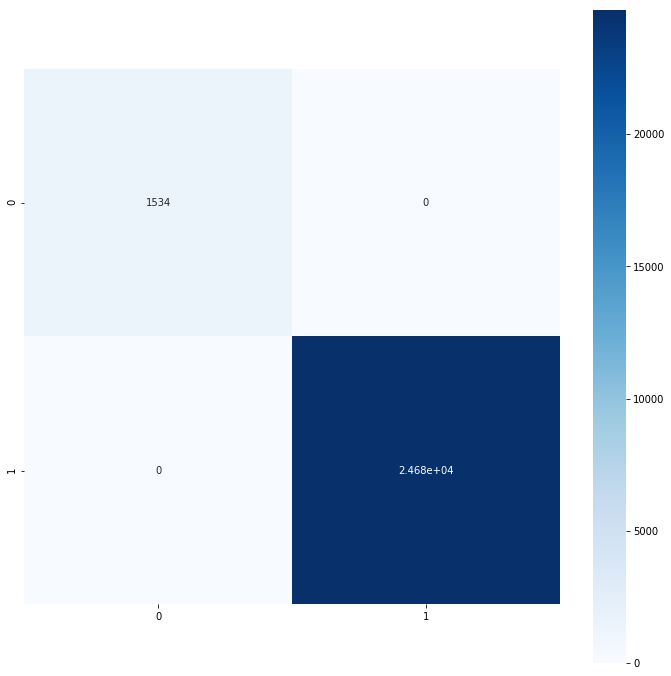

In [14]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

Качество 100%. Это как-то странно.

# Co-co-co-combo

Добавьте в исходную выборку парные признаки — то есть для каждой пары $(f_i, f_j)$, $i < j$ исходных категориальных признаков добавьте новый категориальный признак $f_{ij}$, значение которого является конкатенацией значений $f_i$ и $f_j$ (желательно через какой-нибудь специальный символ во избежание коллизий). Посчитайте счетчики для этой выборки, найдите качество метода $k$ ближайших соседей с наилучшим $k$ (с фолдингом и без).

In [34]:
def get_concat(part_one, part_two):
    return '{}&{}'.format(part_one, part_two)

df_combo = df.copy()
df_columns = list(df.columns)
for j_col_name in df_columns[1:]:
    for i_col_name in df_columns[df_columns.index(col_name)-1::-1]:
        cn = '{}&{}'.format(j_col_name, i_col_name)
        df_combo[cn] = df_combo.apply(lambda x: get_concat(x[j_col_name], x[i_col_name]), axis=1)

In [36]:
df_combo.shape

(32769, 91)

In [37]:
data_combo = pd.DataFrame(index=df_combo.index)
for col_name in df_combo.columns:
    data_combo['counts_{}'.format(col_name)] = df_combo[col_name]
    data_combo['successes_{}'.format(col_name)] = df_combo[col_name]
    for item in df_combo[col_name].unique():
        data_combo.loc[data_combo['counts_{}'.format(col_name)] == item, 'counts_{}'.format(col_name)] = \
            df_combo[df_combo[col_name] == item].shape[0]
        data_combo.loc[data_combo['successes_{}'.format(col_name)] == item, 'successes_{}'.format(col_name)] = \
            df_combo[(df_combo[col_name] == item) & (df_combo['ACTION'] == 1)].shape[0]
    data_combo['smoothed_ratio_{}'.format(col_name)] = \
        (data_combo['counts_{}'.format(col_name)] + 1)/(data_combo['successes_{}'.format(col_name)] + 2)

In [40]:
data_combo['ACTION'] = df_combo['ACTION']

In [41]:
X = data_combo.drop(['ACTION'], axis=1)
y = data_combo['ACTION']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.8)

val_p = (1,2,4,6)
for p in val_p:
    clf = KNeighborsClassifier(n_neighbors=5, p=p)
    print("for p={} mean: {}".format(p, cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').mean()))
    print("for p={} std: {}".format(p, cross_val_score(clf, X, y, cv=5, scoring='neg_mean_squared_error').std()))

for p=1 mean: 0.0
for p=1 std: 0.0
for p=2 mean: 0.0
for p=2 std: 0.0
for p=4 mean: 0.0
for p=4 std: 0.0
for p=6 mean: 0.0
for p=6 std: 0.0


In [42]:
clf = KNeighborsClassifier(n_neighbors=5)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test).astype('int')

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1534
           1       1.00      1.00      1.00     24682

   micro avg       1.00      1.00      1.00     26216
   macro avg       1.00      1.00      1.00     26216
weighted avg       1.00      1.00      1.00     26216



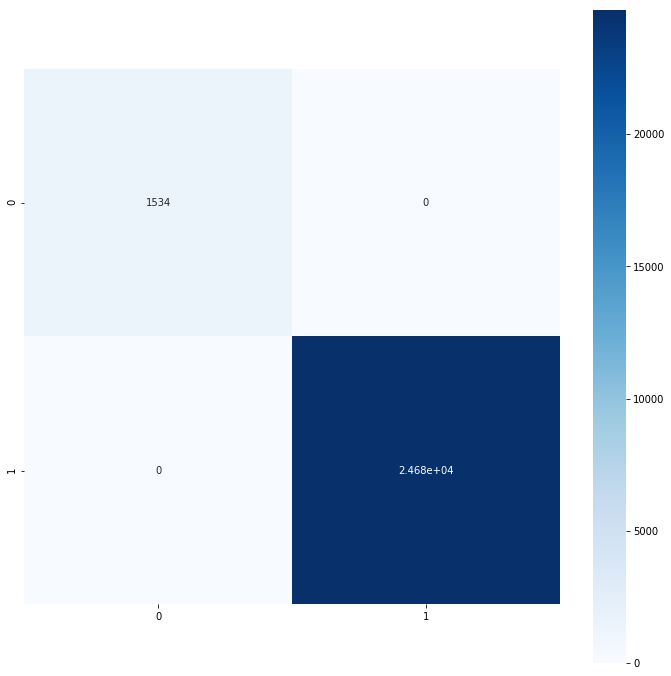

In [43]:
plt.figure(figsize=(12,12)) 
_ = sns.heatmap(confusion_matrix(y_test, y_pred), cmap=plt.cm.Blues, square=True, annot=True, fmt='.4g')

- постройте отчет классификации (classification_report)
- постройте confusion matrix и нарисуйте heatmap

Оцените на сколько улучшилось качество. Не похоже ли это на переобусение?

Внимание! Обучение на этом этапе может быть долгим. На i5 16GB кроссвалидация на 5 фолдах заняла 30 минут!

Качество не улучшилось. Видимо этот этап был лишним. 

# Дополнительное задание

Для тех, кто хочет поставить точку в рекомендательных системах.

### Рекомендательная система и kNN

В прошлый раз мы использовали kMeans, тоже метрический алгоритм, но кластеризации, для построения "рекомендательной ситсемы". На самом деле тогда вы строили кластеры жанров/фильмов на основе предпочтений пользователей.  

Теперь попробуем kNN для рекомендаций. Мы построим модель, в которой не будет кластеров, но которая сможет выводить список наиболее похожих фильмов для заданного.

Подготовка датасета похожа на то, что мы уже делали. Отличаться будет только последний пункт, когда мы запустим kNN с косинусной метрикой.

Будем использовать известный нам [датасет с оценками фильмов](http://www.cs.umn.edu/GroupLens). Только в этот раз мы не будем кластеризовывать жанры, а будем рекомендовать похожие фильмы, основываясь на оценках других пользователей. То есть мы будем по факту предсказывать предпочтение нового пользователя на основе других.

Для рекомендательной системы в датасете в объектами будут пользователи, а признаками - оценки фильма данным пользователем.

![](https://i.imgur.com/hn3xjZl.png)

Мы будем использовать метрический алгоритм для поиска ближайших соседей, тем самым рекомендовать фильмы близкие к данному.

In [ ]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
movies = pd.read_csv('../../data/imdb_movies.csv.gz', index_col='movieId')
ratings = pd.read_csv('../../data/imdb_ratings.csv.gz')

print(movies.shape)
print(ratings.shape)

In [ ]:
movies.head()

In [ ]:
ratings.head()

### 1.1 Поиск популярных фильмов (3 балла)

Среди всех фильмов есть не популярные, для которых выставлена 1-2 оценки. Такого количества данных не достаточно, поэтому нужно срезать много фильмов с маленьким числом отзывов.

Посчтитайте количество оценок для каждого фильма.

Выведите сводную статистику по количеству оценок фильмов. (общее число фильмов, среднее количество оценок, дисперсию, квантили)

Как мы видим `75%` квантиль показывет, что `75%` фильмов имело очень мало оценок. Нам столько будет недостаточно. Посчтитайте квантили в диапазоне от `75%` до `100%` с шагом в `1%`. Выберите тот квантиль, при котором количество оценок равно 20. Напишите какой это квантиль. Напишите сколько всего фильмов останется, если отбросить все фильмы у которых рейтинг меньше этого квантиля.

### 1.2 Соединяем таблицы (1 балл)

Будет немного не удобно искать фильмы по их идентификаторам, нам нужны названия. Поэтому соедините две таблицы `ratings` и `movies` по `movieId` и отфильтруйте отзывы на редкие фильмы, которые мы нашли в предыдущем шаге. Выведите первые 5 элементов полученного датасета.

### 1.3 Матрица Фильмы-Пользователи

В нашем случае мы будем искать похожие фильмы, поэтому сделайте из датасета оценок матрицу, где в строках фильмы, в колонках пользователи, а в ячейках оценки. Пропущенные значение, то есть отсутсвие оценки, заполните 0.

Для увеличения скорости выполнения алгоритма ближайших соседей примените функцию [`scipy.sparse.csc_matrix`](https://docs.scipy.org/doc/scipy/reference/generated/scipy.sparse.csr_matrix.html),  которая создаст плотное представление нашей разреженой матрицы.

### 1.4 Тренировка модели рекомендаций 

Так как по сути у нас нет каких-то меток классов, мы будем использовать алгоритма без учителя [`sklearn.neighbors.NearestNeighbors`](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html). Научите его по данным нашей матрицы пользователей-фильмов и напишите **функцию**, принимающую на вход название фильма и возвращающую список из 6 рекомендованых фильмов, начиная от более похожего.

Для определения "похожести" двух фильмов мы будем использовать косинусную меру, вместо евклидова или минковского:

$$\LARGE cos(\overrightarrow{x},\overrightarrow{y}) = \frac{\overrightarrow{x} \cdot \overrightarrow{y}}{||\overrightarrow{x}|| \times ||\overrightarrow{y}||}$$

In [ ]:
def similar(name='Pulp Fiction (1994)', n=6):
    # Тут какой-то код
    pass

Выведите рекомендации для фильмов:
- `Pulp Fiction (1994)`
- `Star Wars: Episode V - The Empire Strikes Back (1980)`
- `Lord of the Rings: The Two Towers, The (2002)`

In [ ]:
similar('Pulp Fiction (1994)')

In [ ]:
similar('Star Wars: Episode V - The Empire Strikes Back (1980)')

In [ ]:
similar('Lord of the Rings: The Two Towers, The (2002)')

### 1.5 Как посчитать качество рекомендации?

Как посчитать качество нашей классификации? У нас нет учителя, нет отложенной выборки. Мы просто посчитали все рейтинги и на основе них сделали предположения о похожести товаров. 

А как вы думаете можно проверить качество нашей рекомендательной системы? Напишите развернутый ответ своими словами.

???

![](https://69.media.tumblr.com/06a071083b3e62cd76f31af07ecb895f/tumblr_p49r4rWXG21uxovwqo1_540.gif)